In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from sklearn.cluster import KMeans
from Bio import SeqIO, AlignIO
from Bio.Seq import Seq
from collections import Counter
from scipy.stats import gaussian_kde

## Select good C-terminal alignments

In [ ]:
aligns = AlignIO.read("utp-data/c-term-with-cialign.fasta", "fasta")
align_len = len(aligns[0].seq)

# remove gaps
for align in aligns:
    id = " ".join(align.description.split(" ")[1:])
    align.id = id
    align.description = ""
    seq_no_gaps = Seq("".join([char for char in align.seq if char != "-"]))
    align.seq = seq_no_gaps

good_aligns = [align for align in aligns if len(align.seq)/align_len > 0.6]
SeqIO.write(good_aligns, "utp-data/c-term-with-cialign-no-gaps.fasta", "fasta")

## Plot relative positions of motifs

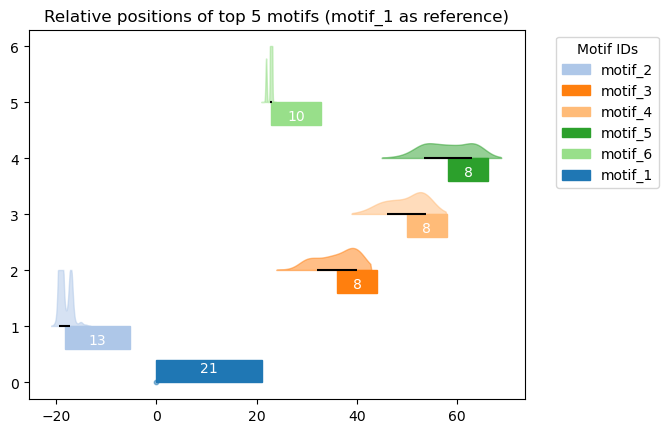

In [3]:
def parse_xml_motifs(file_path):
    meme_xml = ET.parse(file_path)
    return meme_xml

def extract_scanned_sites(meme_xml):
    sites = meme_xml.findall('.//scanned_sites')
    scanned_sites = [
        (tag.attrib["sequence_id"], site.attrib)
        for tag in sites
        for site in tag.findall("scanned_site")
    ]
    return scanned_sites

def compute_relative_positions(scanned_sites, reference_motif="motif_1"):
    motif1_positions = {seq: int(motif["position"]) for seq, motif in scanned_sites if motif["motif_id"] == reference_motif}
    relative_position_occurrances = [
        (seq, motif["motif_id"], int(motif["position"]) - motif1_positions[seq])
        for seq, motif in scanned_sites
        if seq in motif1_positions and motif["motif_id"] != reference_motif
    ]
    return relative_position_occurrances

def plot_motif_positions(relative_position_occurrances, meme_xml, top_n=5):
    motifs = sorted(list(set(( motif for _, motif, _ in relative_position_occurrances  ))), key=lambda motif: int(motif.split("_")[1]))
    
    relative_positions = [[] for _ in motifs]
    for _, motif_id, rel_pos in relative_position_occurrances:
        relative_positions[motifs.index(motif_id)].append(rel_pos)

    motif_seqs = {tag.attrib["id"]: tag.attrib["name"] for tag in meme_xml.findall('.//motif')}
    cmap = matplotlib.colormaps["tab20"]
    _, ax = plt.subplots()
    
    for idx, motif in enumerate(motifs):
        if idx >= top_n:
            break
        rel_pos = relative_positions[motifs.index(motif)]
        mean_pos = np.mean(rel_pos)
        std_pos = np.std(rel_pos)
        
        # print(f"Motif {motif}")
        # print(f"\tcount: {len(rel_pos)}")
        # print(f"\tmean: {mean_pos}")
        # print(f"\tstd: {std_pos}")
        # print(f"\tmin: {min(rel_pos)}")
        # print(f"\tmax: {max(rel_pos)}")
        # print()
        
        base_y = idx + 1
        rect = plt.Rectangle((mean_pos, base_y - 0.4), width=len(motif_seqs[motif]), height=0.4, color=cmap(base_y), label=motif)
        ax.add_patch(rect)
        ax.text(mean_pos + len(motif_seqs[motif])/2, base_y-0.25, f"{len(motif_seqs[motif])}", ha="center", va="center", color="white")
        
        ax.hlines(base_y, mean_pos - std_pos, mean_pos + std_pos, color="black")
        kde = gaussian_kde(rel_pos)
        x = np.linspace(min(rel_pos) - 1, max(rel_pos) + 1, 100)
        y = kde(x) * 4
        y = np.clip(y, 0, 1)
        y[0] = 0
        y[-1] = 0
        ax.fill(x, base_y + y, color=cmap(base_y), alpha=0.5)
    
    # Draw reference motif
    rect = plt.Rectangle(
        (0, 0),
        width=len(motif_seqs["motif_1"]),
        height=0.4,
        color=cmap(0),
        label="motif_1",
    )
    ax.add_patch(rect)
    plt.scatter(0, 0, color=cmap(0), alpha=0.5, s=10)
    ax.text(len(motif_seqs["motif_1"]) / 2, 0.25, f"{len(motif_seqs['motif_1'])}", ha="center", va="center", color="white")
    # ax.vlines(len(motif_seqs["motif_1"]), 0, len(top_5_mean_positions)+1, color=cmap(0), linestyle="--", alpha=0.5)
    # ax.vlines(0, 0, len(top_5_mean_positions)+1, color=cmap(0), linestyle="--", alpha=0.5)


    ax.set_title("Relative positions of top 5 motifs (motif_1 as reference)")
    ax.legend(title="Motif IDs", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()
    
file_path = 'utp-data/meme_out/meme.xml'
meme_xml = parse_xml_motifs(file_path)
scanned_sites = extract_scanned_sites(meme_xml)
relative_position_occurrances = compute_relative_positions(scanned_sites)
plot_motif_positions(relative_position_occurrances, meme_xml)

## Read Tomtom results

In [27]:
# read tsv, ignore comments
df = pd.read_csv("utp-data/tomtom.tsv", sep="\t", comment="#")
df

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation
0,TQTQLGACMGALGLHLGSRLD,ELME000293,-9,0.002552,0.495143,0.474833,5,TQTQLGACMGALGLHLGSRLD,DALGL,+
1,TQTQLGACMGALGLHLGSRLD,ELME000346,-3,0.004921,0.954761,0.474833,11,TQTQLGACMGALGLHLGSRLD,FLLALLLALLL,+
2,TQTQLGACMGALGLHLGSRLD,ELME000329,-11,0.009590,1.860430,0.616835,10,TQTQLGACMGALGLHLGSRLD,LLLLLLLLLLLF,+
3,TQTQLGACMGALGLHLGSRLD,ELME000235,-6,0.016369,3.175570,0.789657,8,TQTQLGACMGALGLHLGSRLD,LLLGLLPL,+
4,TQTQLGACMGALGLHLGSRLD,ELME000094,-18,0.041728,8.095250,0.994664,3,TQTQLGACMGALGLHLGSRLD,RGD,+
...,...,...,...,...,...,...,...,...,...,...
134,CGAFLGGVLAS,ELME000329,0,0.010087,1.956900,0.978299,11,CGAFLGGALAS,LLLLLLLLLLLF,+
135,CGAFLGGVLAS,ELME000129,2,0.026434,5.128200,0.999845,7,CGAFLGGALAS,GLPGERLLG,+
136,CGAFLGGVLAS,ELME000235,-2,0.035702,6.926220,0.999845,8,CGAFLGGALAS,LLLGLLPL,+
137,CGAFLGGVLAS,ELME000477,-3,0.036071,6.997710,0.999845,4,CGAFLGGALAS,FLLP,+


In [33]:
df["Query_ID"].value_counts(), len(df["Query_ID"].unique())

(Query_ID
 LPDFPEPF                 18
 PPAAPGDAACEWLGE          17
 WRAALLGRAP               15
 BLPEFPPG                 15
 PPIPRLLP                 13
 ALGRPPAA                 13
 LQLPDFPDF                11
 PPPATSAECESVLEK           9
 TQTQLGACMGALGLHLGSRLD     8
 WLEEWRERLECWW             7
 EPGCEWVE                  7
 CGAFLGGVLAS               6
 Name: count, dtype: int64,
 12)

In [40]:
# Select Query_ID s with E-value < 0.05
signif_df = df[df["p-value"] < 0.05]

# Select best match for each query
best_matches = signif_df.groupby("Query_ID").apply(lambda x: x.loc[x["E-value"].idxmin()], include_groups=False)
best_matches["Overlap percent"] = best_matches["Overlap"] / best_matches["Query_consensus"].apply(len)
best_matches

,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation,Overlap percent
Query_ID,,,,,,,,,,
ALGRPPAA,ELME000347,1,0.003756,0.728612,0.496195,8,ALGRPPAA,LLLGWPPLLLLRL,+,1.000000
BLPEFPPG,ELME000565,-1,0.001382,0.268075,0.180774,7,DLPAFPPG,LPALPPKL,+,0.875000
CGAFLGGVLAS,ELME000359,1,0.001290,0.250346,0.250307,7,CGAFLGGALAS,SCGHLLAL,+,0.636364
EPGCEWVE,ELME000330,2,0.010861,2.107120,0.851932,5,EPGCEWVE,SLELGRL,+,0.625000
LPDFPEPF,ELME000124,-3,0.000250,0.048576,0.046104,5,LPDFPEPF,FLDLF,+,0.625000
LQLPDFPDF,ELME000452,-2,0.000179,0.034742,0.034267,5,LQLPDFPDF,LLDFP,+,0.555556
PPAAPGDAACEWLGE,ELME000058,0,0.000559,0.108437,0.102422,5,PPAAPGDAACEWLGE,PPLLF,+,0.333333
PPIPRLLP,ELME000004,0,0.000210,0.040755,0.039305,4,PPIPRLLP,PPLP,+,0.500000
PPPATSAECESVLEK,ELME000064,-1,0.002677,0.519250,0.409560,7,PPPATGAECESVLEQ,LLLSLLE,+,0.466667
